# Clone this github Repo

In [ ]:
!git clone https://github.com/c17hawke/FSDS-pytorch-CNN.git

Cloning into 'FSDS-pytorch-CNN'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 24 (delta 7), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 24.62 KiB | 8.21 MiB/s, done.
Resolving deltas: 100% (7/7), done.


# Lets Change runtime (cpu to GPU)

* install req.txt

In [ ]:
%cd /content/FSDS-pytorch-CNN

/content/FSDS-pytorch-CNN


In [ ]:
! pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn # nn means neural network
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


In [ ]:
# make configuration

class Config:
  def __init__(self):
    self.ROOT_DATA_DIR="FashionMNISTDir"
    self.epoch=10
    self.batct_size=32
    self.learning_rate=0.001
    self.Image_size=(28,28)
    self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
    print(f"this notebook using this device:{self.DEVICE}")
    self.SEED=2022

config=Config()



this notebook using this device:cuda


In [ ]:
train_data=datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=True, # true means we want to train this
    download=True,
    transform=transforms.ToTensor()


)

test_data=datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=False, # true means we want to train this
    download=True,
    transform=transforms.ToTensor()


)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]


Extracting FashionMNISTDir/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]


Extracting FashionMNISTDir/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]


Extracting FashionMNISTDir/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.63MB/s]


Extracting FashionMNISTDir/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNISTDir/FashionMNIST/raw



In [ ]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [ ]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [ ]:
train_data.class_to_idx  # see the labels

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
#reverse the dict:
t=train_data.class_to_idx
t1={val:key for key, val in t.items()}
t1

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

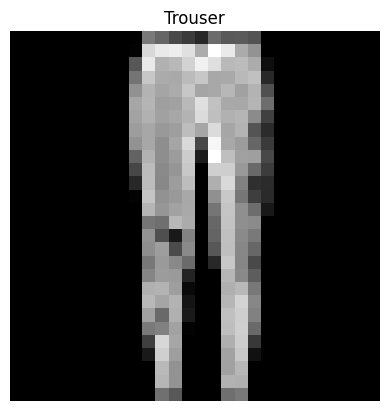

In [ ]:
def View_sample_img(data,idx,label_map):
  plt.imshow(data.data[idx],cmap="gray")
  plt.title(t1[data.targets[idx].item()])
  plt.axis("off")

View_sample_img(train_data,78,t1)

In [ ]:
# nOw create The dataloader

train_data_loader=DataLoader(
    dataset=train_data,
    batch_size=config.batct_size,
    shuffle=True
)

test_data_loader=DataLoader(
    dataset=test_data,
    batch_size=config.batct_size,
    shuffle=False
)

In [ ]:
for image, label in test_data_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


Here (28,28) is image size ; 1 is single channel (black) 32 : is batch size;

In [ ]:
image[0].shape

torch.Size([1, 28, 28])

In [ ]:
image[0].squeeze().shape

torch.Size([28, 28])

In [ ]:
image[0].unsqueeze(dim=1).shape # ([1, 1, 28, 28]) :batch, channel, (28,28)image size

torch.Size([1, 1, 28, 28])

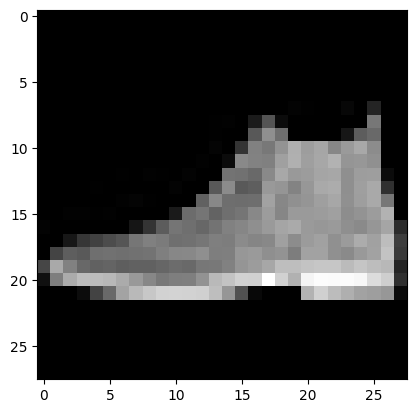

In [ ]:
#now pass this in Imshow
plt.imshow(image[0].squeeze(),cmap="gray")

Now Define  CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features=out_)

  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = F.relu(x)
    x = self.FC_02(x)
    x = F.relu(x)
    x = self.FC_03(x)
    return x

In [ ]:
model = CNN(1, 10)

print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
model.conv_pool_02

Sequential(
  (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
next(model.parameters()).is_cuda

False

In [ ]:
model.to(config.DEVICE)


CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
import pandas as pd


In [ ]:
def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0}
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total parameters: {total}")
  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=config.learning_rate)

In [ ]:
for epoch in range(config.epoch):
  with tqdm(train_data_loader) as tqdm_epoch:
    for image, label in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch{epoch+1}/{config.epoch}")

      # put the image on device
      image=image.to(config.DEVICE)
      label=label.to(config.DEVICE)

      #forword pass
      outputs=model(image)
      loss=criterion(outputs,label)

      #baword propagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() #weight updated

      tqdm_epoch.set_postfix(loss=loss.item())


Epoch10/10: 100%|██████████| 1875/1875 [00:20<00:00, 90.07it/s]


# Save the model

In [ ]:
os.makedirs("model_dir",exist_ok=True)
model_file_path=os.path.join("model_dir","CNN_Model.pth")
torch.save(model,model_file_path)

#load the model

In [ ]:
load_model=torch.load(model_file_path)

<ipython-input-38-e780a90acad7>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model=torch.load(model_file_path)


#Evulate our model

In [ ]:
pred=np.array([])
target=np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_data_loader):
    images=data[0].to(config.DEVICE)
    labels=data[1].to(config.DEVICE)
    y_pred=model(images)

    pred=np.concatenate((pred,torch.argmax(y_pred,1).cpu().numpy()))
    target=np.concatenate((target,labels.cpu().numpy()))


In [ ]:
cm=confusion_matrix(target,pred)

In [ ]:
cm

array([[771,   1,   5,  15,   4,   1, 197,   0,   6,   0],
       [  0, 980,   1,   9,   2,   0,   6,   0,   2,   0],
       [ 13,   0, 813,   6,  82,   0,  85,   0,   1,   0],
       [ 19,   7,  10, 871,  47,   0,  44,   0,   2,   0],
       [  1,   1,  28,  12, 880,   0,  78,   0,   0,   0],
       [  0,   0,   0,   0,   0, 974,   0,  16,   0,  10],
       [ 66,   0,  45,  20,  70,   0, 795,   0,   4,   0],
       [  0,   0,   0,   0,   0,   8,   0, 967,   0,  25],
       [  9,   1,   3,   3,   3,   6,  13,   5, 957,   0],
       [  0,   0,   0,   0,   0,   7,   0,  34,   0, 959]])

<Axes: >

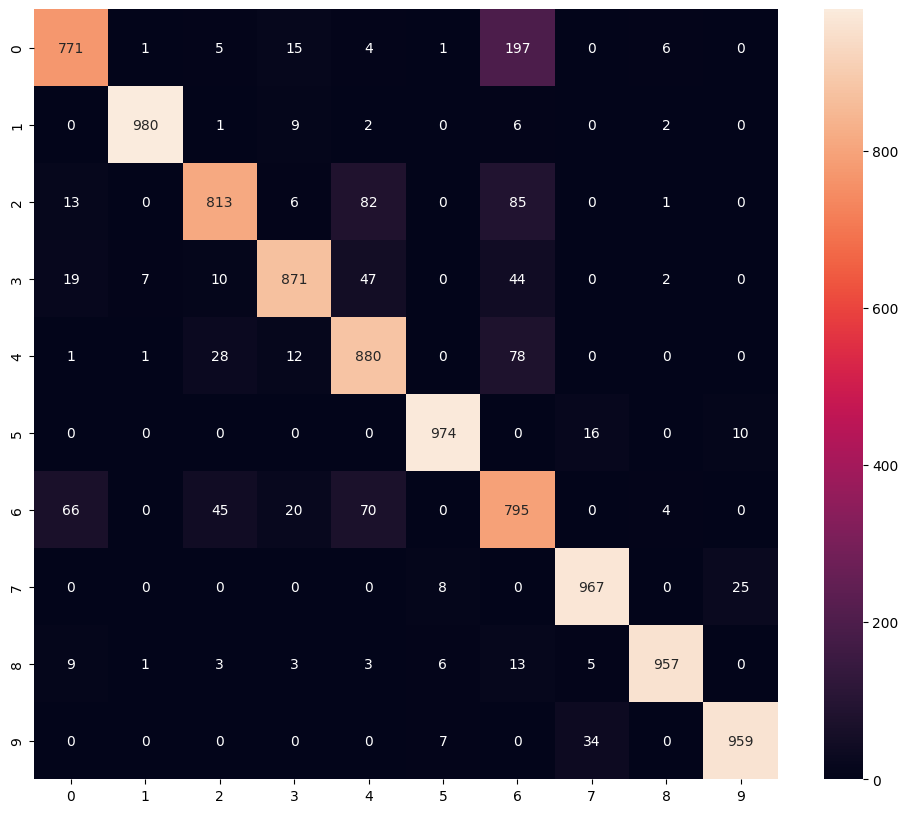

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True,fmt='d')

<Axes: >

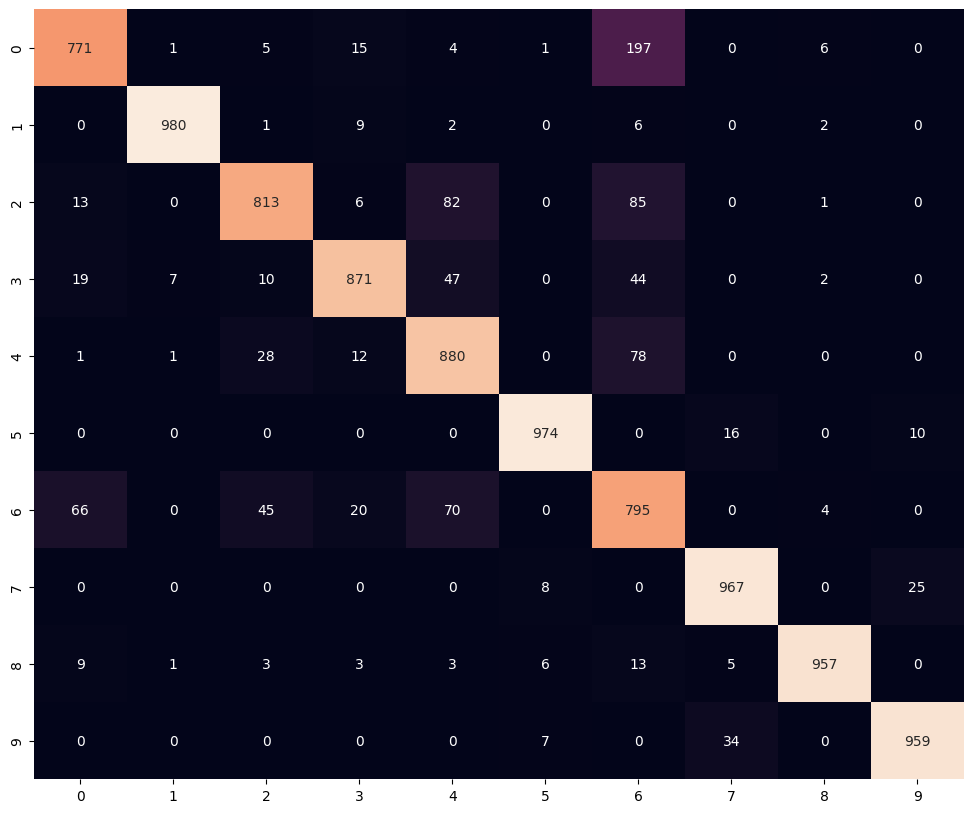

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True,fmt='d',cbar=False)

<Axes: >

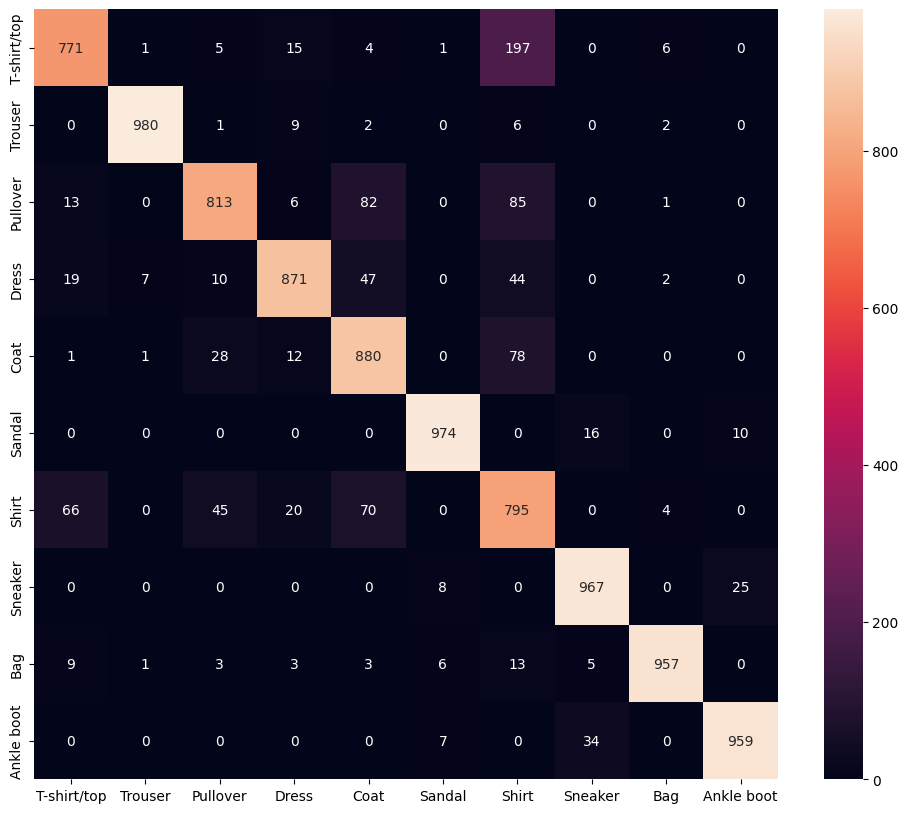

In [ ]:
#label_map
plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=t1.values(),yticklabels=t1.values())

# Prediction on our model

In [ ]:
data=next(iter(test_data_loader))
data

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [ ]:
images,labels=data

In [ ]:
images.shape

torch.Size([32, 1, 28, 28])

In [ ]:
idx=2
img=images[idx]
img.shape

torch.Size([1, 28, 28])

In [ ]:
img.unsqueeze(dim=1).shape

torch.Size([1, 1, 28, 28])

In [ ]:
def predict(data, model, label_map, device, idx=0):
    images, labels = data
    img = images[idx]
    label = labels[idx]

    plt.imshow(img.squeeze(), cmap="gray")
    logit = model(img.unsqueeze(dim=1).to(device))
    pred_prob = F.softmax(logit, dim=1)
    argmax = torch.argmax(pred_prob).item()

    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]

    plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


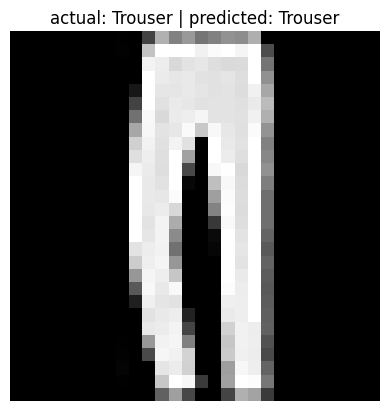

In [ ]:
predict(data, model, t1, config.DEVICE, idx=2)